In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pickle

In [25]:
full_data = pd.read_csv('weatherAUS.csv')
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

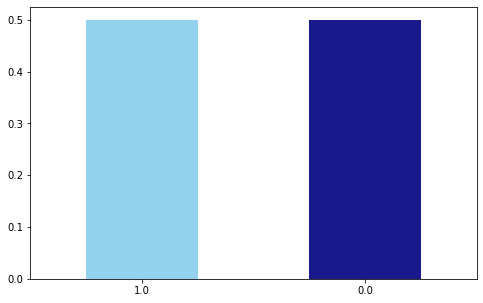

In [5]:
from sklearn.utils import resample
no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)

In [6]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


In [7]:
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [8]:
# Convert categorical features to continuous features with Label Encoding
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [9]:
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [10]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [11]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170669, 23)

In [12]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)


In [13]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


In [14]:
X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03253427 0.02881107 0.03314079 0.03249158 0.02143225 0.03311921
 0.13843799 0.02077917 0.04263648 0.021398   0.02169729 0.02179529
 0.02339751 0.0344056  0.10634039 0.0483552  0.06129439 0.05797767
 0.13958632 0.03162141 0.03627126 0.01247686]


In [15]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [16]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(128001, 21) (42668, 21) (128001,) (42668,)


In [18]:
print(X_train.ndim, X_test.ndim, y_train.ndim, y_test.ndim)

2 2 1 1


In [20]:
X_train[0]

array([ 0.31030605, -0.37217617, -0.19060856, -0.4920702 ,  2.02054799,
        1.62103495,  0.20562378, -0.35434752,  0.91151855,  0.91748898,
        0.45191238,  0.10794732, -0.99229957, -1.24778743,  1.15066185,
        1.4950401 , -0.68722667, -1.38343229, -0.43865058, -0.0704133 ,
       -0.48097589])

In [23]:
type(y_train)

pandas.core.series.Series

In [29]:
# XGBoost

params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)

model_xgb.fit(X_train,y_train)

[18:50:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9496109496578232

In [45]:
X_test

array([[ 0.52634346, -0.74371047, -0.03322575, ..., -0.51976512,
         0.08909827, -0.48486482],
       [-0.95944813,  0.39509364,  0.82715746, ...,  0.86526796,
         0.95243561, -0.48486482],
       [ 1.16311129,  1.20174655,  2.36991357, ...,  1.99558232,
         2.51250134, -0.48486482],
       ...,
       [ 0.10183158,  0.9644957 ,  1.82104842, ...,  1.34286558,
         1.92179684, -0.48486482],
       [-1.24245605, -1.15494528, -0.50791993, ..., -0.69488425,
        -0.42587488, -0.48486482],
       [ 0.24333554,  0.94867897,  0.38213166, ...,  1.00854725,
         0.48290127, -0.48486482]])

In [56]:
model_xgb.predict(X_test[[4]])

array([0.])

In [53]:
y_test

123799    1.0
7517      0.0
49430     0.0
54910     1.0
45191     0.0
         ... 
29852     0.0
29451     0.0
74395     0.0
60041     0.0
23561     1.0
Name: RainTomorrow, Length: 42668, dtype: float64

In [60]:
features[0:1]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2.0,13.4,22.9,0.6,5.734653,7.446035,13.0,44.0,13.0,14.0,...,24.0,71.0,22.0,1007.7,1007.1,8.0,4.848545,16.9,21.8,0.0


In [61]:
pd.set_option('display.max_columns', 5400)

In [84]:
features[99:100]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
127,2.0,7.5,22.5,0.0,4.665841,9.690323,9.0,28.0,8.0,8.0,7.0,7.0,55.0,27.0,1026.7,1023.5,2.473596,2.843551,13.3,21.6,0.0


In [76]:
target

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
134889    1.0
129024    1.0
133585    1.0
87307     1.0
27220     1.0
Name: RainTomorrow, Length: 170669, dtype: float64

In [78]:
import numpy as np
XX1 = np.array([[2.0,13.4,22.9,0.6,5.734653,7.446035,13.0,44.0,13.0,14.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,4.848545,16.9,21.8,0.0]])
XX2 = np.array([[2.0,7.4,25.1,0.0,5.639329,11.520531,14.0,44.0,6.0,15.0,4.0,22.0,44.0,25.0,1010.6,1007.8,1.731945,2.625892,17.2,24.3,0.0]])

In [80]:
model_xgb.predict(XX1)
model_xgb.predict(XX2)

array([1.])

In [89]:
full_data[50:60]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
50,2009-01-20,Albury,18.6,39.9,0.0,NaN,NaN,NNW,61.0,SSE,WNW,9.0,20.0,36.0,21.0,1010.1,1004.8,NaN,NaN,26.8,37.7,0.0,0.0
51,2009-01-21,Albury,19.3,38.1,0.8,NaN,NaN,NNW,61.0,NE,WSW,15.0,17.0,48.0,17.0,1009.6,1005.9,NaN,NaN,27.3,36.1,0.0,0.0
52,2009-01-22,Albury,24.4,34.0,0.6,NaN,NaN,NW,98.0,N,NNW,26.0,48.0,60.0,39.0,1005.3,997.8,4.0,1.0,26.1,33.1,0.0,1.0
53,2009-01-23,Albury,18.8,35.2,6.4,NaN,NaN,WNW,52.0,S,NW,6.0,28.0,43.0,28.0,1007.9,1003.9,NaN,NaN,22.8,33.0,1.0,0.0
54,2009-01-24,Albury,20.8,30.6,0.0,NaN,NaN,W,54.0,W,W,30.0,28.0,41.0,21.0,1005.4,1007.6,NaN,NaN,23.3,29.7,0.0,0.0
55,2009-01-25,Albury,14.0,34.3,0.0,NaN,NaN,WSW,24.0,ESE,SSE,7.0,13.0,44.0,10.0,1016.5,1014.6,NaN,NaN,21.2,32.1,0.0,0.0
56,2009-01-26,Albury,15.7,38.4,0.0,NaN,NaN,S,33.0,SSE,WSW,7.0,7.0,48.0,12.0,1017.7,1014.6,NaN,NaN,23.4,36.5,0.0,0.0
57,2009-01-27,Albury,18.5,38.2,0.0,NaN,NaN,NNE,31.0,SE,NNW,9.0,17.0,48.0,25.0,1017.8,1014.1,NaN,NaN,25.8,36.2,0.0,0.0
58,2009-01-28,Albury,20.4,40.7,0.0,NaN,NaN,N,37.0,E,NNE,7.0,13.0,45.0,15.0,1014.9,1011.6,NaN,NaN,28.2,39.2,0.0,0.0
59,2009-01-29,Albury,21.8,41.5,0.0,NaN,NaN,SW,24.0,ESE,S,6.0,11.0,38.0,13.0,1015.7,1011.8,NaN,NaN,29.0,40.1,0.0,0.0


In [92]:
features[100:120]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
128,2.0,8.2,24.0,0.0,4.348928,10.399552,10.0,17.0,10.0,10.0,7.0,13.0,60.0,30.0,1027.1,1023.4,2.457706,2.489922,13.8,23.5,0.0
129,2.0,8.1,25.7,0.0,4.064880,10.355763,1.0,22.0,2.0,8.0,9.0,13.0,67.0,27.0,1024.2,1019.6,2.467993,2.626369,15.1,25.0,0.0
133,2.0,9.9,25.4,0.0,4.253453,9.219086,5.0,19.0,1.0,11.0,4.0,7.0,65.0,35.0,1023.0,1018.7,2.970857,3.136182,16.1,25.0,0.0
134,2.0,12.2,25.0,0.0,4.656726,7.243123,14.0,30.0,3.0,13.0,0.0,15.0,68.0,39.0,1016.3,1011.6,6.000000,4.353985,16.2,24.6,0.0
135,2.0,10.7,21.9,0.0,6.621241,11.292612,13.0,63.0,7.0,13.0,26.0,31.0,44.0,27.0,1008.2,1009.8,2.000000,3.395855,20.5,18.9,0.0
136,2.0,3.5,20.0,0.0,3.196158,9.392027,13.0,31.0,3.0,14.0,0.0,13.0,65.0,30.0,1016.3,1012.8,2.951010,3.127786,9.6,19.4,0.0
137,2.0,6.6,21.6,0.0,4.464556,9.563985,14.0,26.0,1.0,13.0,6.0,11.0,59.0,39.0,1018.5,1016.8,5.000000,1.000000,12.6,21.6,0.0
138,2.0,7.0,23.4,0.0,3.417438,10.053984,13.0,24.0,10.0,13.0,2.0,17.0,73.0,37.0,1022.8,1019.3,3.008384,2.831400,12.4,22.9,0.0
139,2.0,11.2,23.9,0.0,5.030767,9.863632,9.0,31.0,9.0,9.0,13.0,15.0,54.0,33.0,1022.7,1019.6,2.695286,2.961776,18.0,23.6,0.0
140,2.0,7.4,22.0,0.0,4.050094,9.600976,10.0,28.0,9.0,9.0,2.0,7.0,58.0,29.0,1023.6,1020.0,2.542845,2.916443,14.1,21.3,0.0


In [93]:
# Creating a pickle file for the model
filename = 'Rainfall_Prediction.pkl'
pickle.dump(model_xgb, open(filename, 'wb'))

In [94]:
#save the data columns
import json

columns = {'data_columns' : [col.lower() for col in features]}

with open("columns.json","w") as f:
    f.write(json.dumps(columns))    

In [104]:
(columns.items())

dict_items([('data_columns', ['location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm', 'windspeed9am', 'windspeed3pm', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm', 'raintoday'])])

In [97]:
len(columns)

1

In [108]:
with open("columns.json", "r") as f:
    data_columns = json.load(f)['data_columns']
x = np.zeros(len(data_columns))
len(x)

21

In [109]:
x = np.zeros(21)

In [128]:
x

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [118]:
#model_xgb.predict(x)

In [123]:
np.zeros??

In [154]:
x1 = np.zeros((21,))
print(x1.ndim)
print(len(x1))
x1

1
21


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [183]:
x2 = np.zeros(21)
print(len(features.columns))
x2 = np.reshape(x2, newshape=(1, len(features.columns)), order='C')
print(x2.ndim)
print(len)
x2[0][0] = 3
x2

21
2
<built-in function len>


array([[3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

In [176]:
x2 = np.zeros(21)

In [194]:
XX1

array([[2.000000e+00, 1.340000e+01, 2.290000e+01, 6.000000e-01,
        5.734653e+00, 7.446035e+00, 1.300000e+01, 4.400000e+01,
        1.300000e+01, 1.400000e+01, 2.000000e+01, 2.400000e+01,
        7.100000e+01, 2.200000e+01, 1.007700e+03, 1.007100e+03,
        8.000000e+00, 4.848545e+00, 1.690000e+01, 2.180000e+01,
        0.000000e+00]])

In [181]:
with open("columns.json", "r") as f:
        data_columns = json.load(f)['data_columns']

In [182]:
print(len(data_columns))

21


In [184]:
with open('Rainfall_Prediction.pkl', 'rb') as f:
    model = pickle.load(f)

In [193]:
if model.predict(x2) == 0:
    print('No more')
else:
    print('Servived')

No more
